# Make a simple FeedForward network for the bus data

## Initialization

In [9]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
from BaseNetwork import BaseNetwork
import torch
from torch.nn import Linear, Sequential, ReLU, L1Loss, Dropout
from torch.optim import Adam, lr_scheduler
import numpy as np
%load_ext autoreload
%autoreload 2

## Import data using the MoviaBusDataset

In [2]:
previous_timesteps = 6
prediction_steps = 6
batch_size = 25
num_epochs = 25

train = MoviaBusDataset('../data/train', interpolation=True, 
                        prev_timesteps=previous_timesteps, 
                        max_future_time_steps=prediction_steps, 
                        timeofday = True)
test = MoviaBusDataset('../data/test', interpolation=True, 
                       prev_timesteps=previous_timesteps, 
                       max_future_time_steps=prediction_steps, 
                       timeofday = True)

train.normalize()
test.normalize(train.mean, train.std)

## The Model

In [31]:
num_roads = train[0]['target'].size()[1] + 1
class FNN(BaseNetwork):
    def __init__(self, num_hidden):
        super().__init__()
        

        self.FNN = Sequential(
            Dropout(p=0.4),
            Linear((previous_timesteps+1)*num_roads, num_hidden),
            ReLU(),
            Dropout(p=0.4),
            Linear(num_hidden, num_hidden),
            ReLU(),
            Dropout(p=0.4),
            Linear(num_hidden, num_roads),
        )

    def forward(self,x):
        """
        x : [batch_size, prev_timesteps, num_roads]
        
        """
        
        #Transpose input, such that the previous time steps are the last dimension
       # xinput = x.view(-1,(previous_timesteps+1)*(num_roads))

        predictions = []
        for _ in range(self.max_timestep):
            #Run the input through the network
            prediction = self.FNN(x.view(-1,(previous_timesteps+1)*num_roads))
            
            
            prediction = prediction.view(-1, 1, num_roads)
            #Append the prediction to the list of predictions. 
            #If the data includes timeofday, this shouldn't be included
            predictions.append(prediction[:,:,:-1])

            #remove oldest timestep
            x = x[:,1:,:]
            #print(x.size())
            #print(prediction.size())
            #unsqueeze output so its size is [batch_size, num_roads, timesteps]
            #prediction = prediction.unsqueeze(2)

            #append the new prediction to the input
            x = torch.cat((x,prediction),dim=1)


        return torch.stack(predictions,1).squeeze()

net = FNN(num_hidden=117)

optimizer_fun = lambda param : Adam(param, lr=1e-3, weight_decay=1e-3)
scheduler_fun = lambda optim : lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)
criterion = L1Loss()

## Training the network

In [33]:
net.train_network(train, test,batch_size=batch_size, 
                  num_epochs=30,
                  optimizer_fun=optimizer_fun,
                  #scheduler_fun=scheduler_fun,
                  criterion=criterion)

epoch =  0  train loss = 0.711   test loss = 0.746   output_std = 0.282
epoch =  2  train loss = 0.710   test loss = 0.749   output_std = 0.212
epoch =  4  train loss = 0.710   test loss = 0.745   output_std = 0.336
epoch =  6  train loss = 0.710   test loss = 0.745   output_std = 0.279
epoch =  8  train loss = 0.710   test loss = 0.750   output_std = 0.167
epoch = 10  train loss = 0.709   test loss = 0.745   output_std = 0.364
epoch = 12  train loss = 0.710   test loss = 0.745   output_std = 0.346
epoch = 14  train loss = 0.709   test loss = 0.743   output_std = 0.349
epoch = 16  train loss = 0.709   test loss = 0.745   output_std = 0.248
epoch = 18  train loss = 0.710   test loss = 0.743   output_std = 0.292
epoch = 20  train loss = 0.709   test loss = 0.744   output_std = 0.210
epoch = 22  train loss = 0.709   test loss = 0.744   output_std = 0.309
epoch = 24  train loss = 0.709   test loss = 0.742   output_std = 0.305
epoch = 26  train loss = 0.709   test loss = 0.743   output_std 

## Evaluate the network on a test dataset 

In [34]:
scores=[net.get_MAE_score(timestep=i) for i in range(1,prediction_steps+1)]
print(scores)
print(sum(scores)/len(scores))

[1.5913724899291992, 1.5967806577682495, 1.600611925125122, 1.6035890579223633, 1.6072490215301514, 1.610837697982788]
1.6017401417096455


### Example of modelled data vs real data for one road segment 

<IPython.core.display.Javascript object>


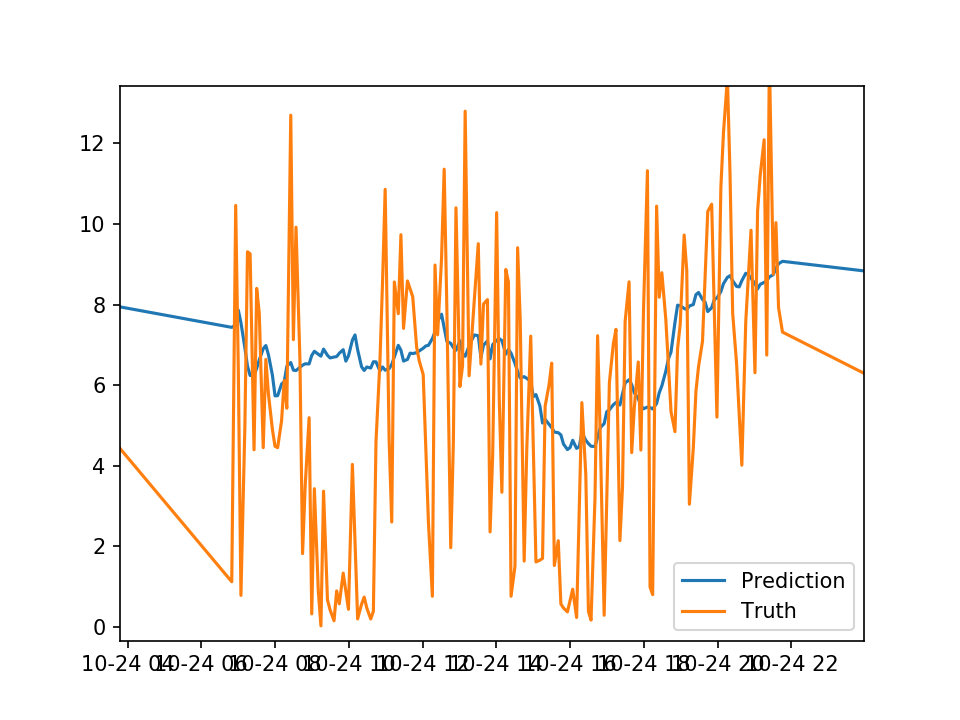

In [41]:
%matplotlib notebook

net.visualize_road(timesteps=4, road=14)